# MindLens-AI -- Notebook 05: Robustness Testing (RQ3)

**RQ3:** Are model predictions sensitive to small input perturbations (e.g., keyword removal or synonym replacement), indicating reliance on spurious correlations?

We apply two perturbation strategies to a subset of the test set and measure how often the predicted label flips. A flip rate above 15% would indicate fragility.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from src.model import load_model
from src.robustness import remove_keywords, synonym_replace, robustness_test, TRIGGER_KEYWORDS
from src.trust import compute_trust_score, categorize_trust, generate_trust_report

sns.set_theme(style="whitegrid")

model, vectorizer = load_model("../data/processed/model_artifacts.joblib")
split = joblib.load("../data/processed/test_split.joblib")
X_test = split["X_test"]
y_test = split["y_test"]
test_texts = split["texts_test"]

n_samples = min(300, len(test_texts))
sample_texts = test_texts[:n_samples]

print(f"Robustness testing on {n_samples} samples.")
print(f"Using {len(TRIGGER_KEYWORDS)} trigger keywords.")

Robustness testing on 300 samples.
Using 29 trigger keywords.


## 1. Perturbation Tests

In [2]:
print("Running keyword removal test...")
kw_results = robustness_test(model, vectorizer, sample_texts, remove_keywords)
print(f"  Flip rate: {kw_results['flip_rate']:.4f} ({kw_results['n_flips']}/{kw_results['n_total']})")

print("\nRunning synonym replacement test...")
syn_results = robustness_test(model, vectorizer, sample_texts, synonym_replace, n=3, rng_seed=42)
print(f"  Flip rate: {syn_results['flip_rate']:.4f} ({syn_results['n_flips']}/{syn_results['n_total']})")

Running keyword removal test...
  Flip rate: 0.0367 (11/300)

Running synonym replacement test...
  Flip rate: 0.0500 (15/300)


## 2. Flip Rate Comparison

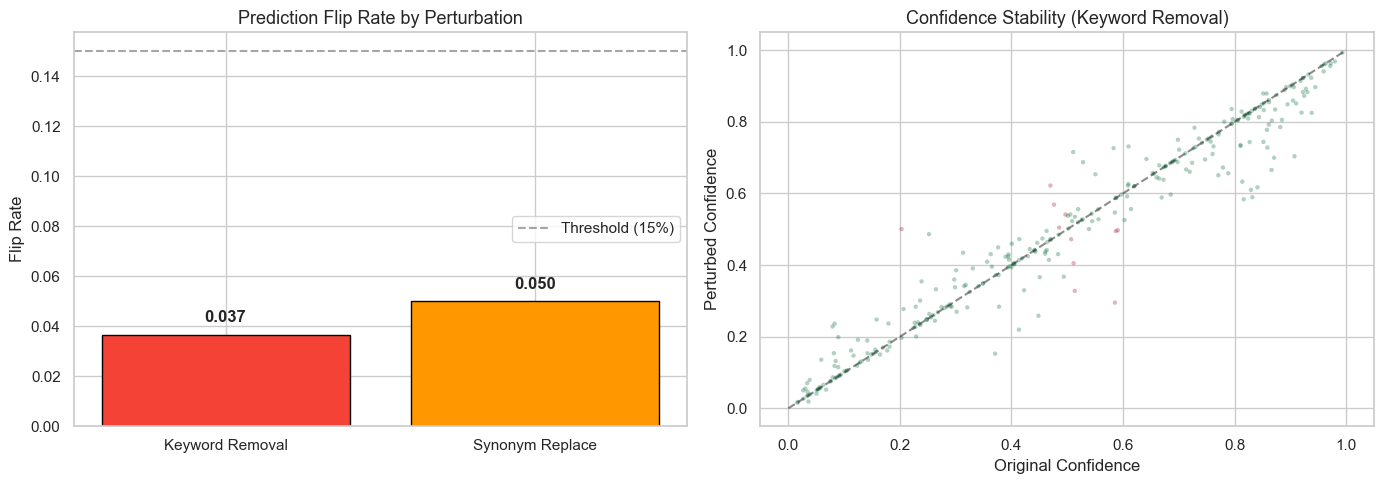

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Flip rates
perturbations = ["Keyword Removal", "Synonym Replace"]
flip_rates = [kw_results["flip_rate"], syn_results["flip_rate"]]
colors = ["#F44336", "#FF9800"]

bars = axes[0].bar(perturbations, flip_rates, color=colors, edgecolor="black")
for bar, val in zip(bars, flip_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{val:.3f}", ha="center", fontweight="bold", fontsize=12)
axes[0].axhline(0.15, color="gray", linestyle="--", alpha=0.7, label="Threshold (15%)")
axes[0].set_ylabel("Flip Rate")
axes[0].set_title("Prediction Flip Rate by Perturbation", fontsize=13)
axes[0].legend()

# Scatter: Original vs Perturbed confidence (keyword removal)
axes[1].scatter(kw_results["original_conf"], kw_results["perturbed_conf"],
                alpha=0.3, s=10, c=kw_results["flip_flags"].astype(int),
                cmap="RdYlGn_r", edgecolors="none")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[1].set_xlabel("Original Confidence")
axes[1].set_ylabel("Perturbed Confidence")
axes[1].set_title("Confidence Stability (Keyword Removal)", fontsize=13)

plt.tight_layout()
plt.show()

## 3. Trust Score Demo

In [4]:
bias_data = joblib.load("../data/processed/bias_results.joblib")
bias_gap = bias_data["bias_fpr_gap"]

print("--- Trust Score Reports ---\n")
for i in range(min(5, len(sample_texts))):
    report = generate_trust_report(sample_texts[i], model, vectorizer, bias_gap)
    print(f"Sample {i+1}:")
    print(f"  Prediction:  {report['prediction_label']}")
    print(f"  Confidence:  {report['confidence']:.3f}")
    print(f"  Flip Rate:   {report['flip_rate']:.1f}")
    print(f"  Trust Score: {report['trust_score']:.3f} ({report['trust_label']})")
    print(f"  Text: {sample_texts[i][:100]}...")
    print()

--- Trust Score Reports ---

Sample 1:
  Prediction:  Risk
  Confidence:  0.852
  Flip Rate:   0.0
  Trust Score: 0.726 (High)
  Text: numb sitting here going through the most traumatic time in my life and i can barely even cry maybe i...

Sample 2:
  Prediction:  Risk
  Confidence:  0.923
  Flip Rate:   0.0
  Trust Score: 0.797 (High)
  Text: i think the world would be a better place if i was not here not in a suicidal way i guess but more i...

Sample 3:
  Prediction:  Risk
  Confidence:  0.514
  Flip Rate:   1.0
  Trust Score: 0.000 (Low)
  Text: how to approach parents about counselling or therapy hello i ve had a nagging feeling in my head tha...

Sample 4:
  Prediction:  Risk
  Confidence:  0.750
  Flip Rate:   0.0
  Trust Score: 0.624 (Medium)
  Text: i picked a day and i picked how i m gonna do it...

Sample 5:
  Prediction:  Control
  Confidence:  0.761
  Flip Rate:   0.0
  Trust Score: 0.635 (Medium)
  Text: miss having someone i ve been staring at my screen for the past minu

## 4. RQ3 Conclusion

**H3:** Small perturbations in input text will significantly affect predictions.

If the hypothesis is *not* confirmed, that means the model is robust and does not rely on superficial keyword shortcuts.

In [5]:
kw_flip = kw_results["flip_rate"]
syn_flip = syn_results["flip_rate"]

print("=" * 55)
print("  RQ3 CONCLUSION")
print("=" * 55)
print(f"  Keyword Removal Flip Rate:  {kw_flip:.4f} ({kw_flip*100:.1f}%)")
print(f"  Synonym Replace Flip Rate:  {syn_flip:.4f} ({syn_flip*100:.1f}%)")
print(f"  Threshold:                  15%")
print()

if kw_flip > 0.15 or syn_flip > 0.15:
    print("  >>> H3 CONFIRMED -- the model is sensitive to perturbations.")
    if kw_flip > 0.15:
        print(f"  Keyword removal causes {kw_flip*100:.1f}% flips.")
    if syn_flip > 0.15:
        print(f"  Synonym replacement causes {syn_flip*100:.1f}% flips.")
else:
    print("  >>> H3 NOT CONFIRMED -- the model is *robust* to perturbations.")
    print(f"  Keyword removal:     {kw_flip*100:.1f}% flips (well below 15%)")
    print(f"  Synonym replacement: {syn_flip*100:.1f}% flips (well below 15%)")
    print("  The model does not rely on surface-level trigger words or")
    print("  spurious correlations. This is a positive result.")

joblib.dump({
    "kw_flip_rate": kw_flip,
    "syn_flip_rate": syn_flip,
}, "../data/processed/robustness_results.joblib")

print("\nNotebook 05 complete.")

  RQ3 CONCLUSION
  Keyword Removal Flip Rate:  0.0367 (3.7%)
  Synonym Replace Flip Rate:  0.0500 (5.0%)
  Threshold:                  15%

  >>> H3 NOT CONFIRMED -- the model is *robust* to perturbations.
  Keyword removal:     3.7% flips (well below 15%)
  Synonym replacement: 5.0% flips (well below 15%)
  The model does not rely on surface-level trigger words or
  spurious correlations. This is a positive result.

Notebook 05 complete.
